In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [ ]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [ ]:
SIZE = 256

In [ ]:
root_path = '/content/drive/MyDrive/dataset/real_images/'
classes = sorted(os.listdir(root_path))
classes

['images', 'sr_images']

In [ ]:
single_mask_paths = sorted([sorted(glob( "/content/drive/MyDrive/dataset/masks/*")) for name in classes])


In [ ]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

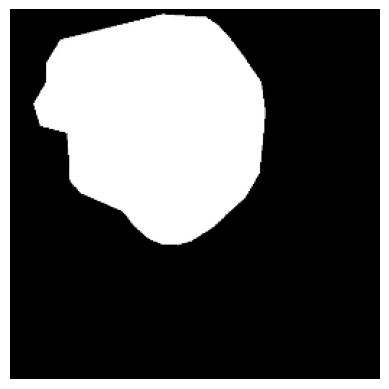

In [ ]:
show_image(load_image(image_paths[0], SIZE))

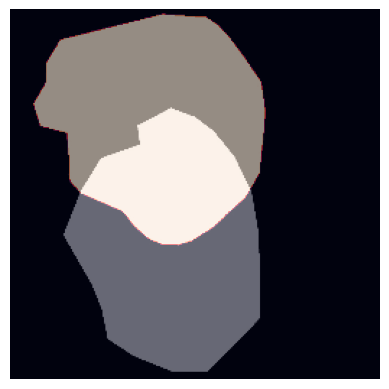

In [ ]:

show_mask(load_image(image_paths[1], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

In [ ]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

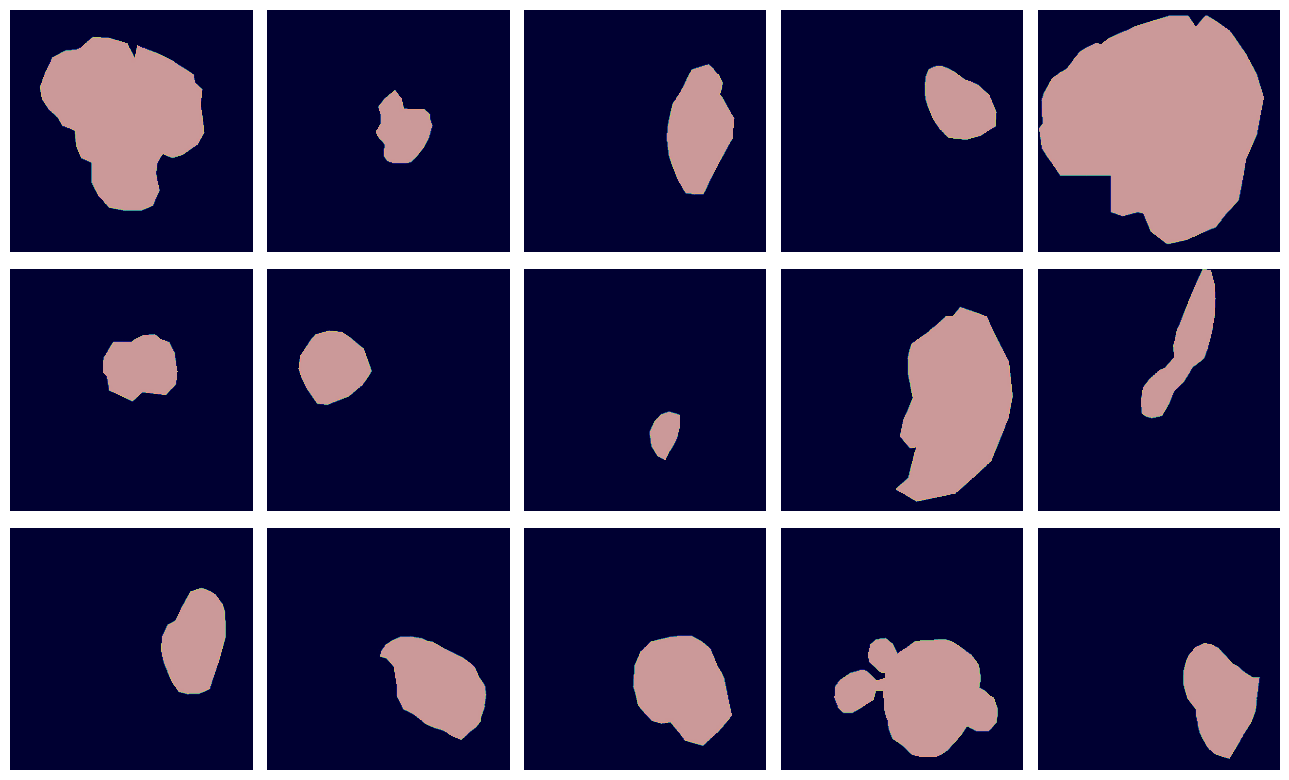

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

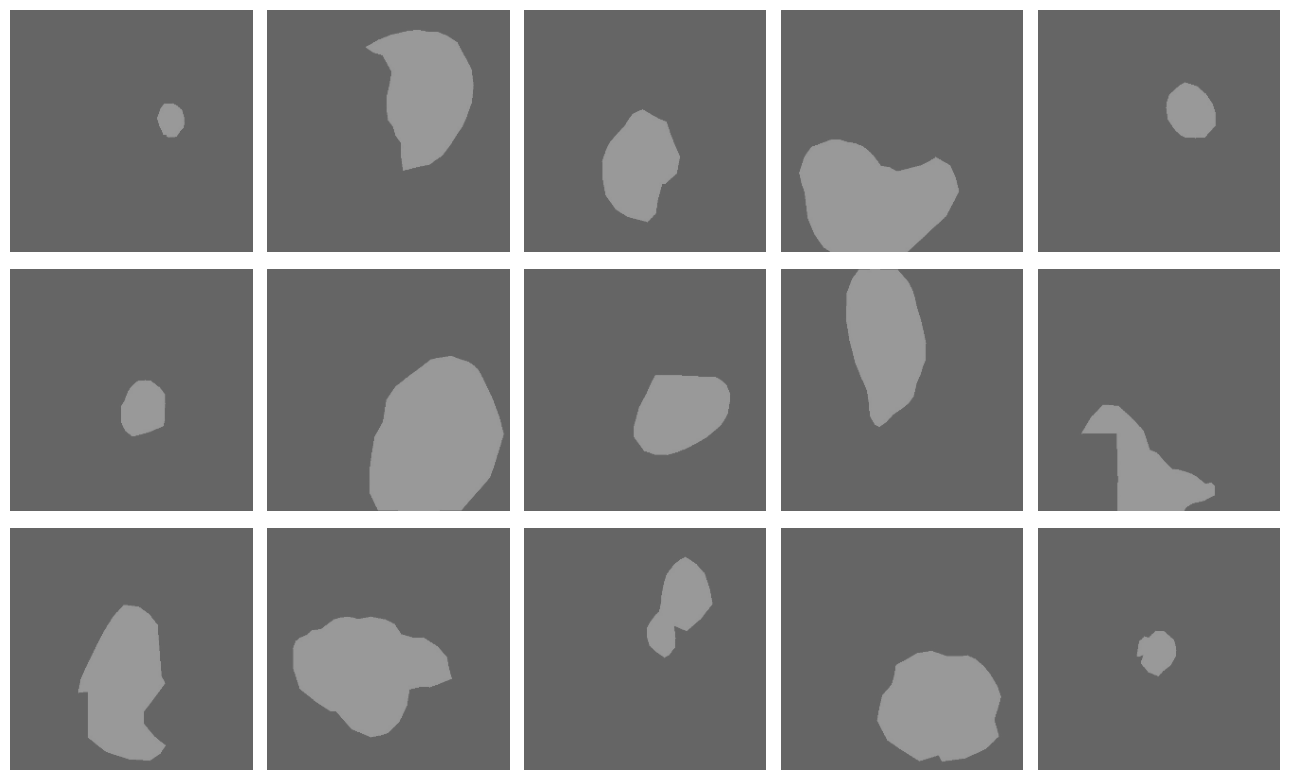

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

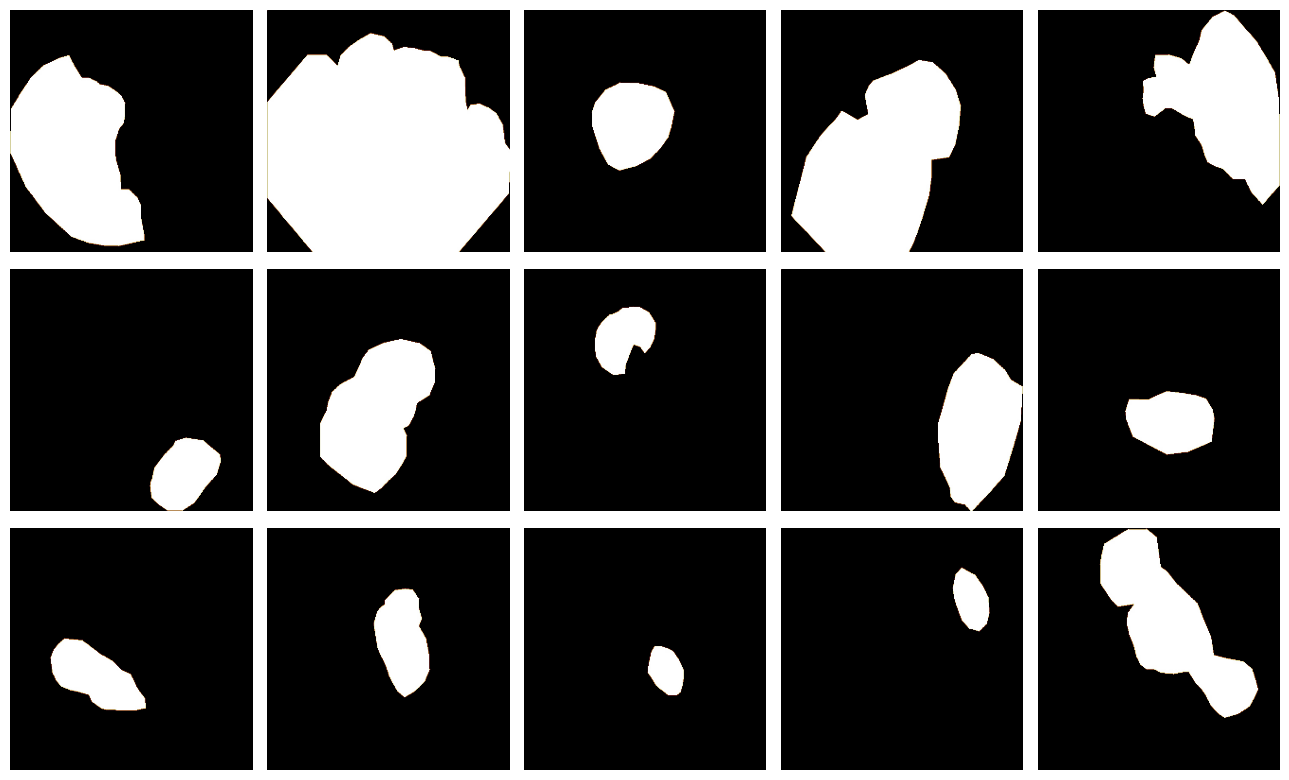

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

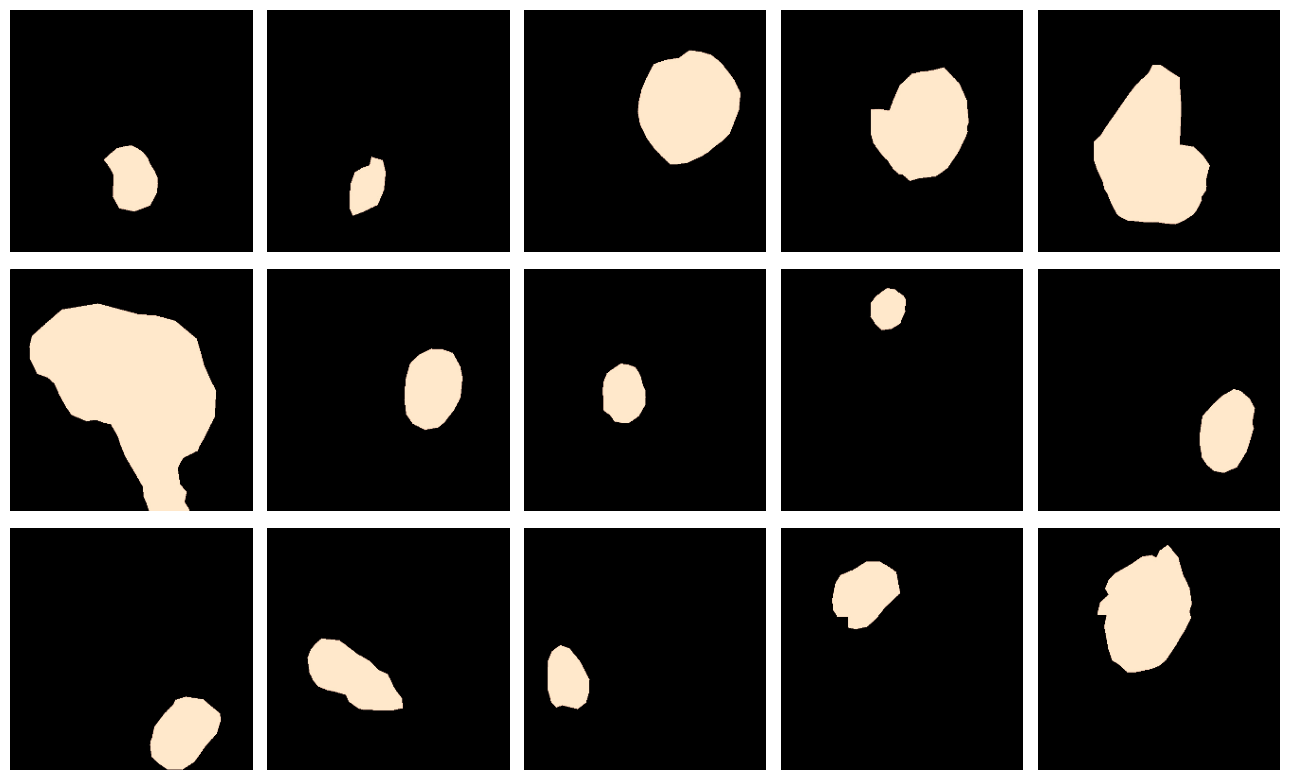

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

In [ ]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
      base_config = super().get_config()
      return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

Epoch 1/20
1/1 [==============================] - 1s 1s/step


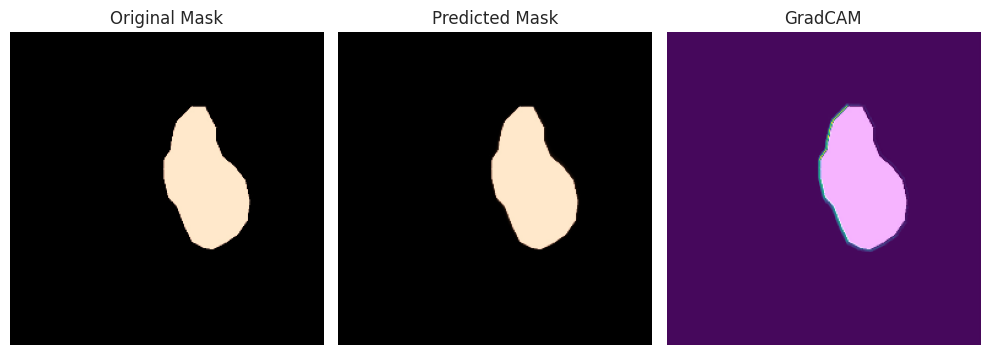

250/250 [==============================] - 109s 303ms/step - loss: 0.0201 - accuracy: 0.9760 - IoU: 0.4374 - val_loss: 0.0043 - val_accuracy: 0.9795 - val_IoU: 0.4216
Epoch 2/20
1/1 [==============================] - 0s 23ms/step


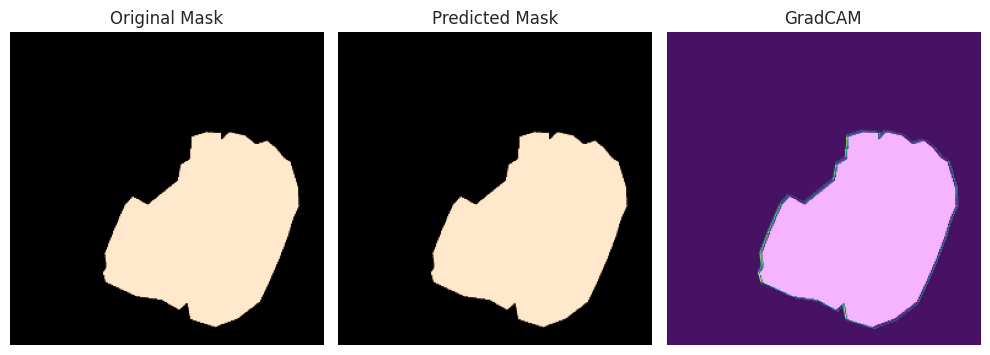

250/250 [==============================] - 77s 306ms/step - loss: 0.0022 - accuracy: 0.9800 - IoU: 0.4392 - val_loss: 0.0026 - val_accuracy: 0.9795 - val_IoU: 0.4216
Epoch 3/20
1/1 [==============================] - 0s 42ms/step


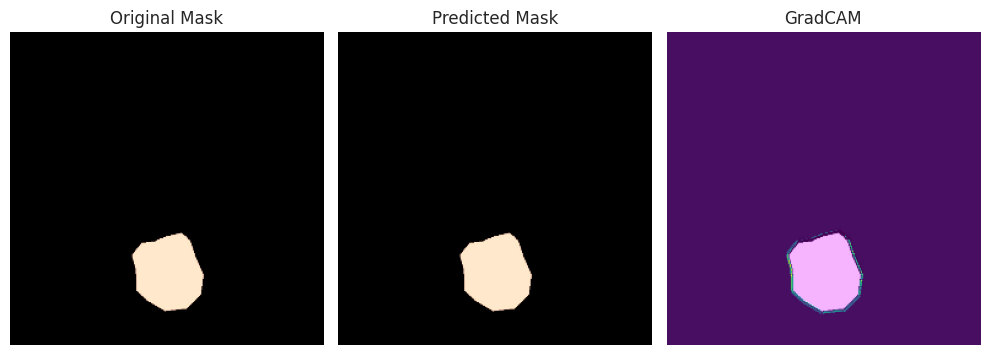

250/250 [==============================] - 74s 297ms/step - loss: 0.0021 - accuracy: 0.9802 - IoU: 0.4491 - val_loss: 0.0021 - val_accuracy: 0.9795 - val_IoU: 0.4216
Epoch 4/20
1/1 [==============================] - 0s 26ms/step


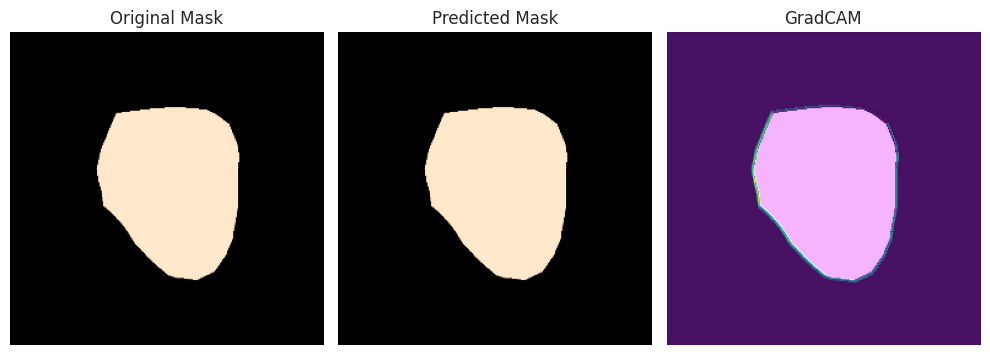

250/250 [==============================] - 78s 311ms/step - loss: 0.0020 - accuracy: 0.9800 - IoU: 0.4858 - val_loss: 0.0021 - val_accuracy: 0.9795 - val_IoU: 0.4216
Epoch 5/20
1/1 [==============================] - 0s 23ms/step


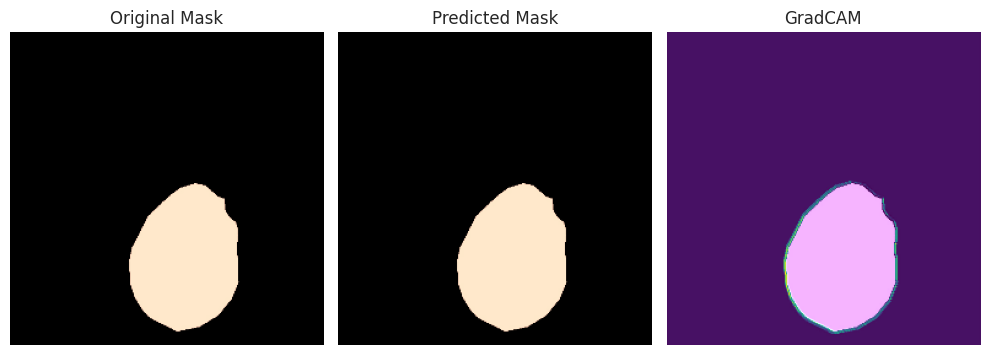

250/250 [==============================] - 71s 283ms/step - loss: 0.0020 - accuracy: 0.9802 - IoU: 0.5296 - val_loss: 0.0021 - val_accuracy: 0.9795 - val_IoU: 0.4216
Epoch 6/20
1/1 [==============================] - 0s 25ms/step


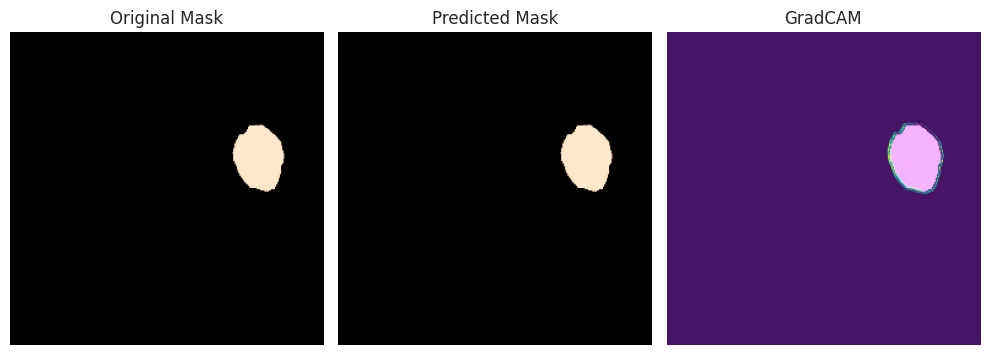

250/250 [==============================] - 77s 309ms/step - loss: 0.0020 - accuracy: 0.9799 - IoU: 0.5526 - val_loss: 0.0020 - val_accuracy: 0.9795 - val_IoU: 0.4216
Epoch 7/20
1/1 [==============================] - 0s 25ms/step


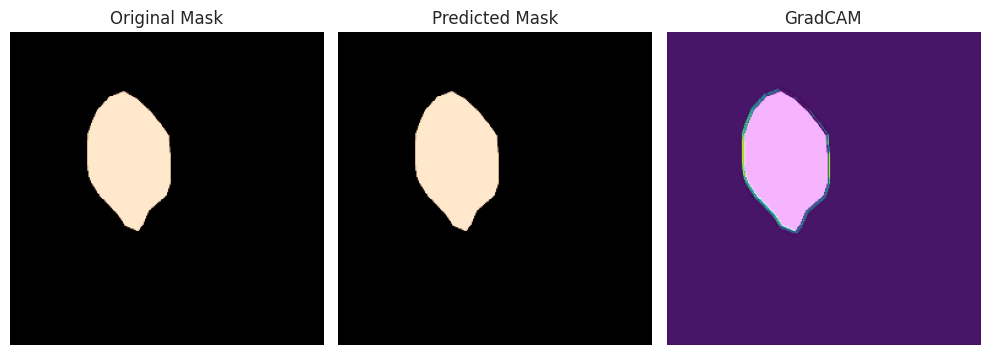

250/250 [==============================] - 73s 291ms/step - loss: 0.0019 - accuracy: 0.9801 - IoU: 0.5777 - val_loss: 0.0020 - val_accuracy: 0.9795 - val_IoU: 0.5306
Epoch 8/20
1/1 [==============================] - 0s 54ms/step


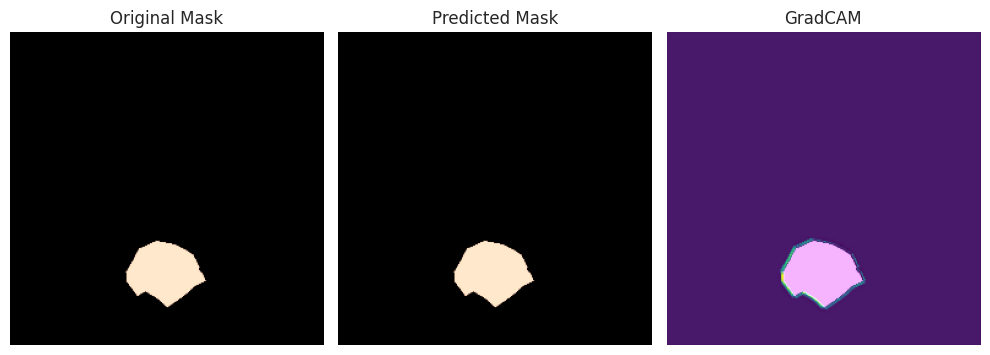

250/250 [==============================] - 75s 299ms/step - loss: 0.0019 - accuracy: 0.9800 - IoU: 0.6102 - val_loss: 0.0020 - val_accuracy: 0.9795 - val_IoU: 0.7850
Epoch 9/20
1/1 [==============================] - 0s 24ms/step


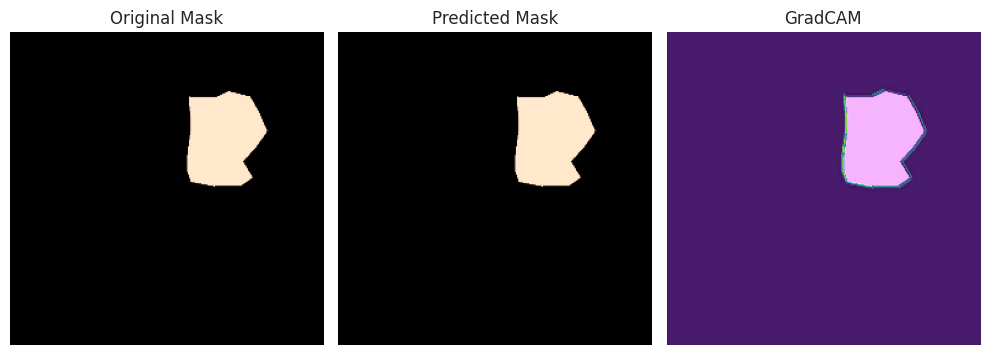

250/250 [==============================] - 77s 308ms/step - loss: 0.0019 - accuracy: 0.9800 - IoU: 0.6353 - val_loss: 0.0020 - val_accuracy: 0.9795 - val_IoU: 0.7792
Epoch 10/20
1/1 [==============================] - 0s 25ms/step


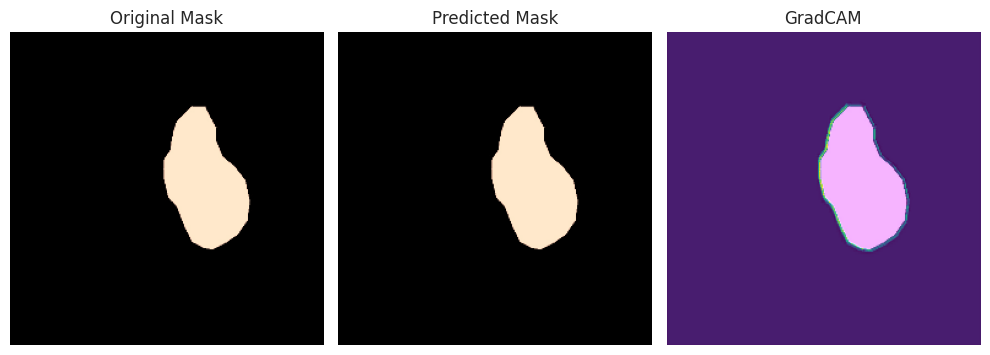

250/250 [==============================] - 71s 285ms/step - loss: 0.0019 - accuracy: 0.9800 - IoU: 0.6471 - val_loss: 0.0020 - val_accuracy: 0.9795 - val_IoU: 0.8101
Epoch 11/20
1/1 [==============================] - 0s 27ms/step


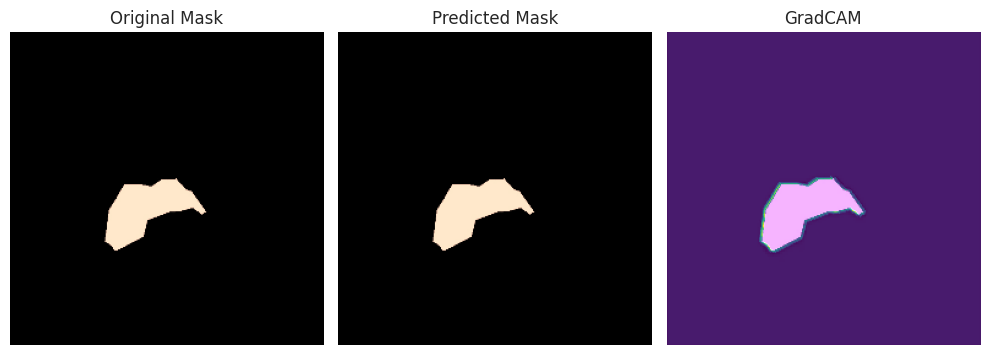

250/250 [==============================] - 78s 312ms/step - loss: 0.0019 - accuracy: 0.9802 - IoU: 0.7192 - val_loss: 0.0020 - val_accuracy: 0.9795 - val_IoU: 0.8421
Epoch 12/20
1/1 [==============================] - 0s 36ms/step


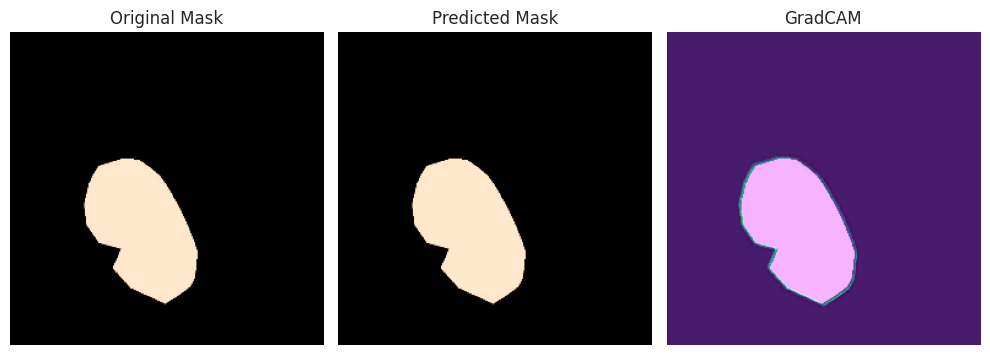

250/250 [==============================] - 77s 309ms/step - loss: 0.0019 - accuracy: 0.9800 - IoU: 0.7169 - val_loss: 0.0019 - val_accuracy: 0.9795 - val_IoU: 0.8209
Epoch 13/20
1/1 [==============================] - 0s 32ms/step


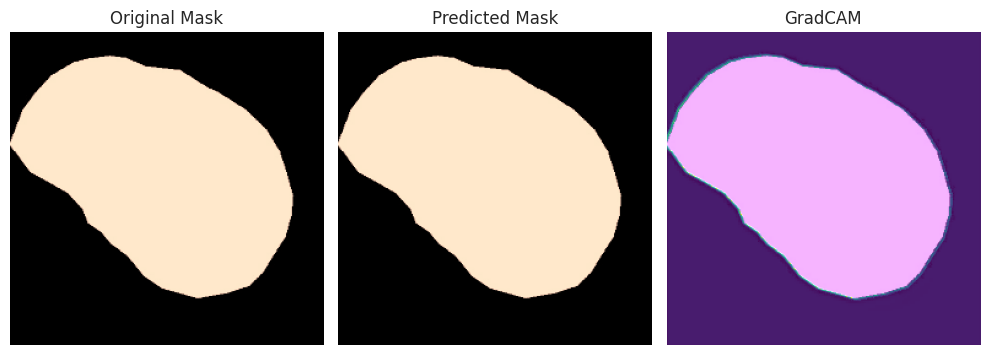

250/250 [==============================] - 77s 307ms/step - loss: 0.0019 - accuracy: 0.9801 - IoU: 0.7581 - val_loss: 0.0019 - val_accuracy: 0.9795 - val_IoU: 0.8347
Epoch 14/20
1/1 [==============================] - 0s 24ms/step


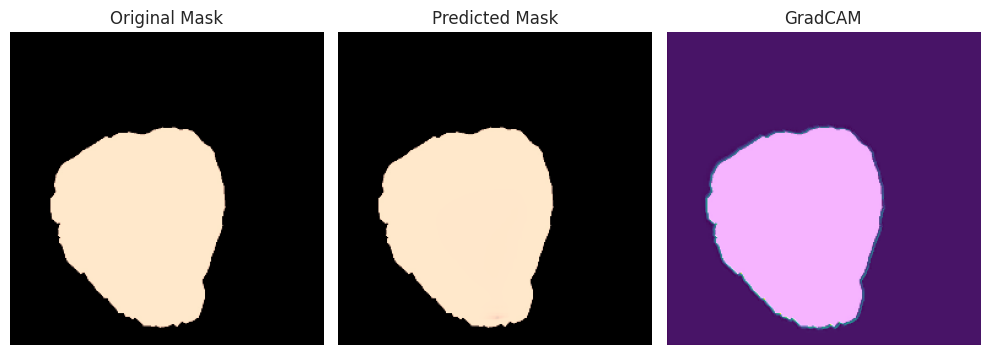

250/250 [==============================] - 72s 287ms/step - loss: 0.0019 - accuracy: 0.9800 - IoU: 0.6831 - val_loss: 0.0037 - val_accuracy: 0.9794 - val_IoU: 0.5670
Epoch 15/20
1/1 [==============================] - 0s 26ms/step


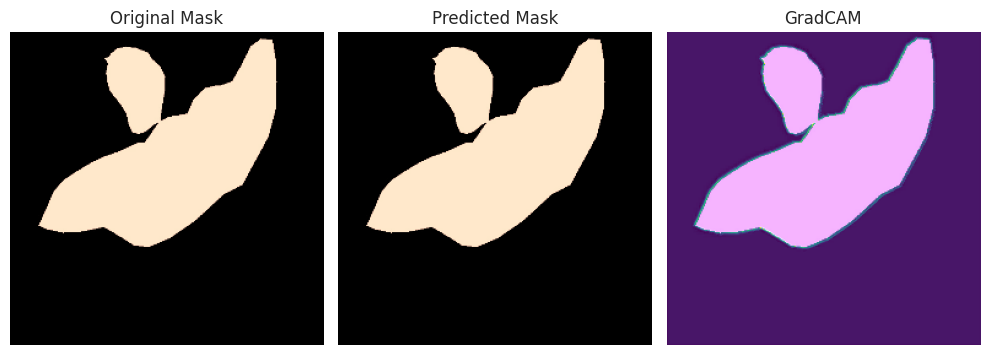

250/250 [==============================] - 74s 295ms/step - loss: 0.0019 - accuracy: 0.9801 - IoU: 0.7703 - val_loss: 0.0021 - val_accuracy: 0.9795 - val_IoU: 0.9576
Epoch 16/20
1/1 [==============================] - 0s 25ms/step


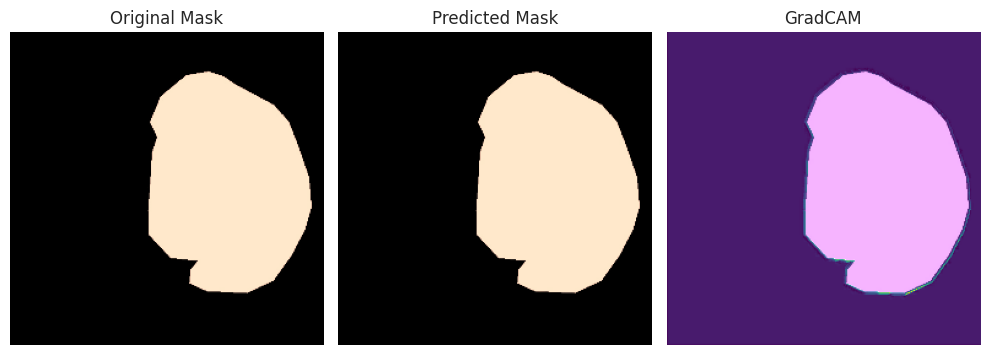

250/250 [==============================] - 72s 287ms/step - loss: 0.0019 - accuracy: 0.9801 - IoU: 0.7711 - val_loss: 0.0021 - val_accuracy: 0.9795 - val_IoU: 0.9444
Epoch 17/20


1/1 [==============================] - 0s 27ms/step


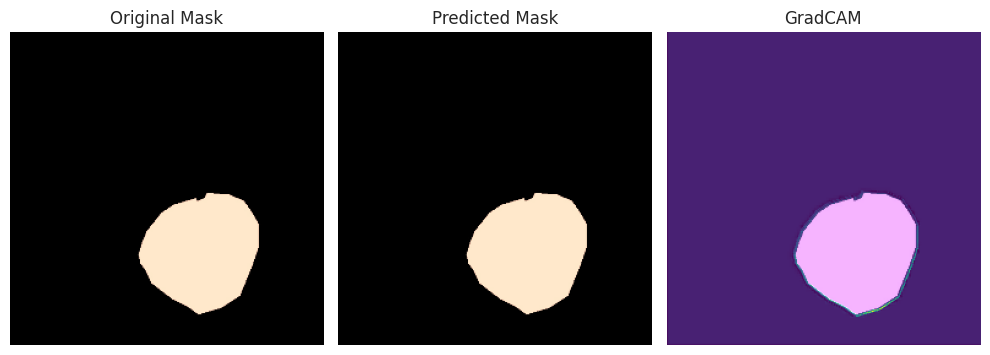

250/250 [==============================] - 4s 17ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - IoU: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.9795 - val_IoU: 0.9444


In [ ]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=20, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

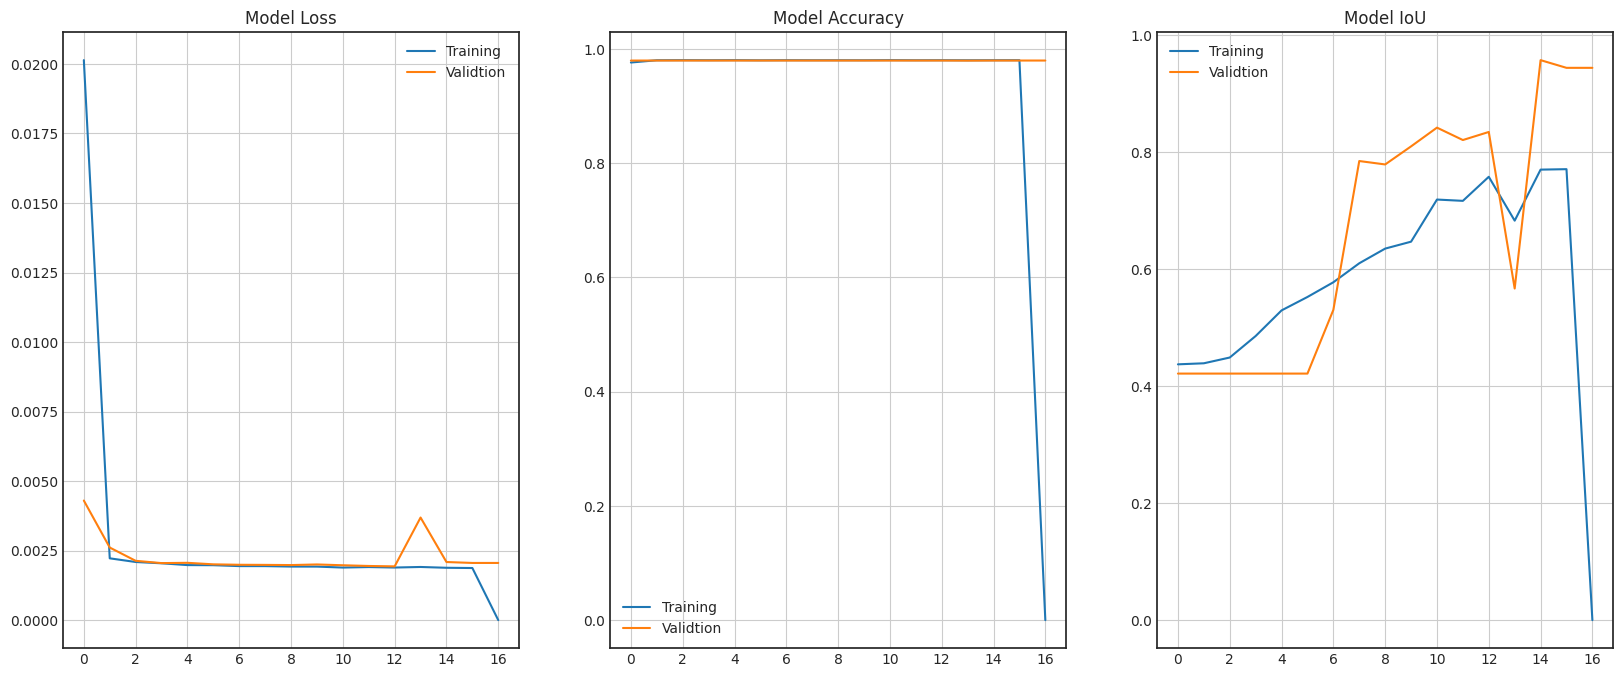

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()